In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, callback #, DMatrix
# import cupy as cp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.metrics import make_scorer

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import KFold
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%config Completer.use_jedi = False

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (750000, 9)
Test Shape: (250000, 8)


In [4]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [7]:
train.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

In [8]:
test.isna().sum()

id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64

# Exploring

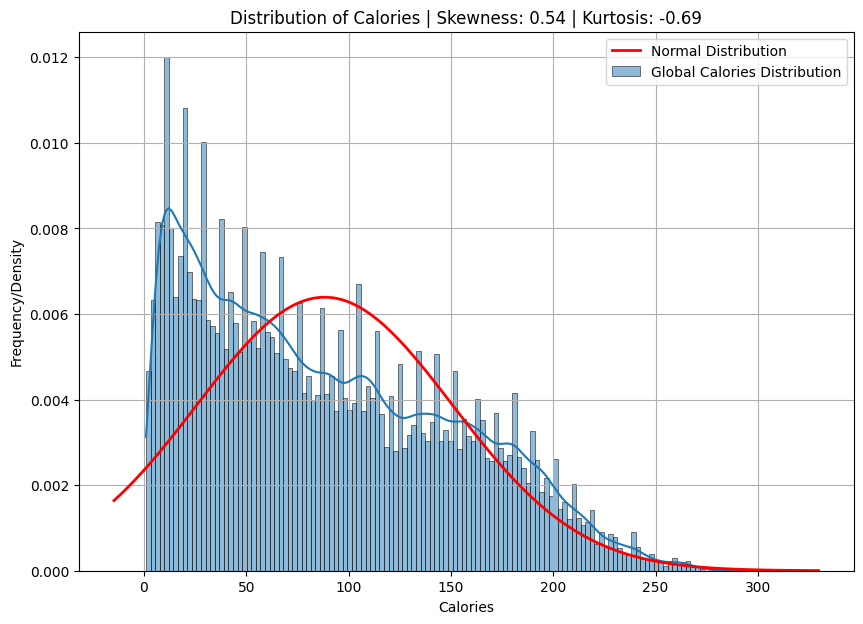

In [9]:
plt.figure(figsize=(10, 7))
sns.histplot(train['Calories'], kde=True, bins='auto', edgecolor='black', label='Global Calories Distribution', stat='density')

mean = train['Calories'].mean()
std = train['Calories'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

plt.grid(True, linestyle='-')
plt.title(f"Distribution of Calories | Skewness: {round(train['Calories'].skew(), 2)} | Kurtosis: {round(train['Calories'].kurtosis(), 2)}")
plt.xlabel('Calories')
plt.ylabel('Frequency/Density')
plt.legend()
plt.show()

- A Skew score of 0.54 indicate a fairly symetrical distribution, even though the visual look otherwise.
- A Kurtosis score of -0.69, we have a negative kurtosis, which mean a flatter peak and tail, also it can mean less extreme/outlier value.

Source: https://www.smartpls.com/documentation/functionalities/excess-kurtosis-and-skewness

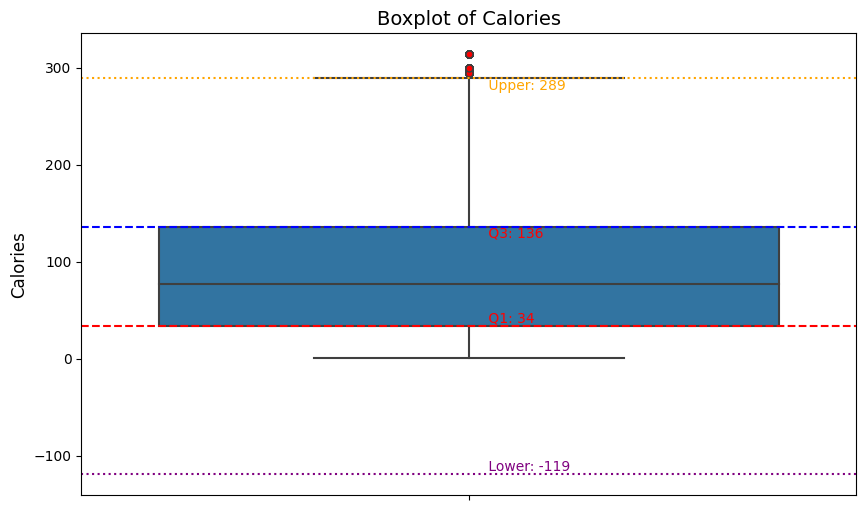

In [10]:
Q1 = train['Calories'].quantile(0.25)
Q3 = train['Calories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(10, 6))
ax = sns.boxplot(y=train['Calories'], flierprops=dict(markerfacecolor='red', marker='o'))

plt.axhline(Q1, color='red', linestyle='--', label=f"Q1 = {Q1:,.0f}")
plt.axhline(Q3, color='blue', linestyle='--', label=f"Q3 = {Q3:,.0f}")
plt.axhline(lower_bound, color='purple', linestyle=':', label=f"Lower Bound = {lower_bound:,.0f}")
plt.axhline(upper_bound, color='orange', linestyle=':', label=f"Upper Bound = {upper_bound:,.0f}")

plt.text(0.02, Q1, f' Q1: {Q1:,.0f}', color='red', va='bottom')
plt.text(0.02, Q3, f' Q3: {Q3:,.0f}', color='red', va='top')
plt.text(0.02, lower_bound, f' Lower: {lower_bound:,.0f}', color='purple', va='bottom')
plt.text(0.02, upper_bound, f' Upper: {upper_bound:,.0f}', color='orange', va='top')


plt.title('Boxplot of Calories', fontsize=14)
plt.ylabel('Calories', fontsize=12)

plt.show()

- With boxplot we can see that we have around 3 data points is extreme value.

In [11]:
male_df = train.where(train['Sex'] == 'male').dropna()
male_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,374279.0,374985.450009,216383.483091,0.0,187459.0,375062.0,562295.5,749998.0
Age,374279.0,41.567724,14.958469,20.0,29.0,40.0,52.0,79.0
Height,374279.0,184.410448,8.589572,141.0,179.0,184.0,191.0,222.0
Weight,374279.0,86.609032,8.951300,46.0,81.0,87.0,93.0,132.0
Duration,374279.0,15.340708,8.449930,1.0,8.0,15.0,23.0,30.0
Heart_Rate,374279.0,95.570366,9.492556,67.0,88.0,95.0,103.0,128.0
Body_Temp,374279.0,40.023803,0.794915,37.1,39.6,40.2,40.7,41.5
Calories,374279.0,89.033683,66.590171,1.0,31.0,73.0,138.0,314.0


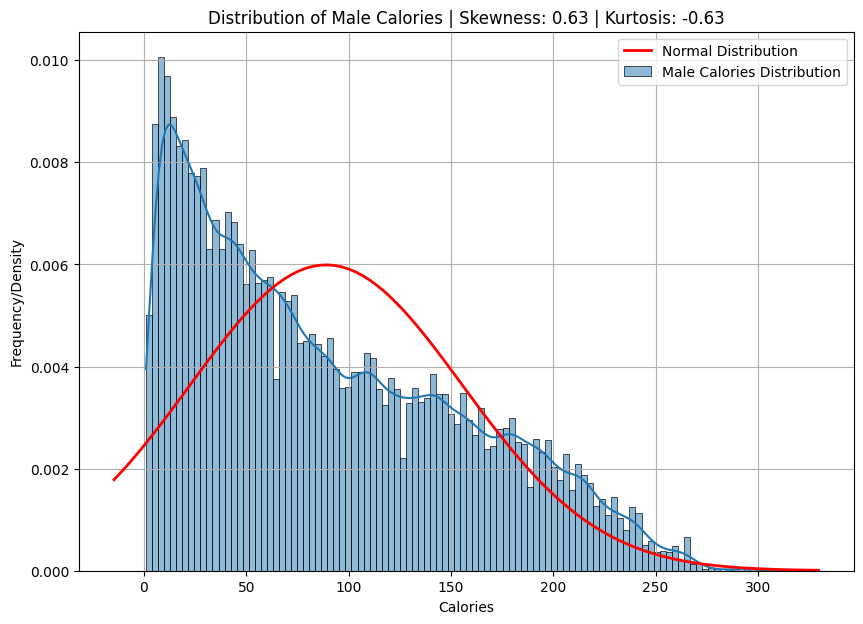

In [12]:
plt.figure(figsize=(10, 7))
sns.histplot(male_df['Calories'], kde=True, bins='auto', edgecolor='black', label='Male Calories Distribution', stat='density')

mean = male_df['Calories'].mean()
std = male_df['Calories'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

plt.grid(True, linestyle='-')
plt.title(f"Distribution of Male Calories | Skewness: {round(male_df['Calories'].skew(), 2)} | Kurtosis: {round(male_df['Calories'].kurtosis(), 2)}")
plt.xlabel('Calories')
plt.ylabel('Frequency/Density')
plt.legend()
plt.show()

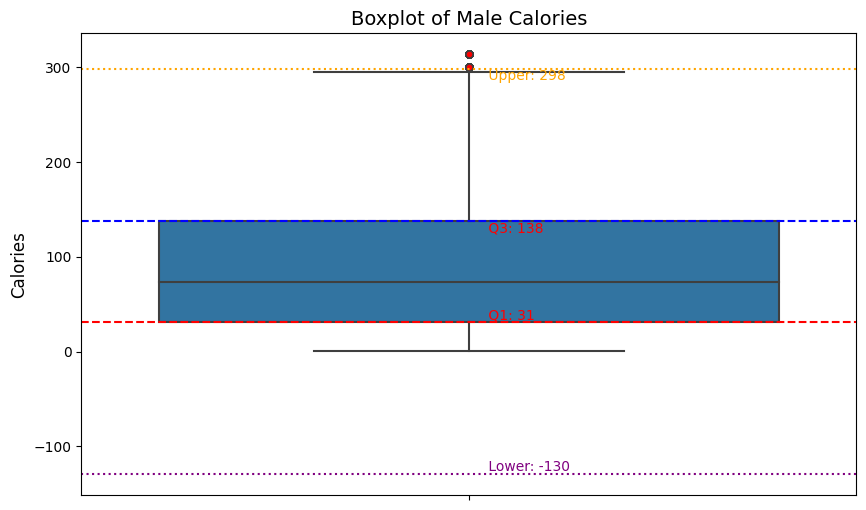

In [13]:
Q1 = male_df['Calories'].quantile(0.25)
Q3 = male_df['Calories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(10, 6))
ax = sns.boxplot(y=male_df['Calories'], flierprops=dict(markerfacecolor='red', marker='o'))

plt.axhline(Q1, color='red', linestyle='--', label=f"Q1 = {Q1:,.0f}")
plt.axhline(Q3, color='blue', linestyle='--', label=f"Q3 = {Q3:,.0f}")
plt.axhline(lower_bound, color='purple', linestyle=':', label=f"Lower Bound = {lower_bound:,.0f}")
plt.axhline(upper_bound, color='orange', linestyle=':', label=f"Upper Bound = {upper_bound:,.0f}")

plt.text(0.02, Q1, f' Q1: {Q1:,.0f}', color='red', va='bottom')
plt.text(0.02, Q3, f' Q3: {Q3:,.0f}', color='red', va='top')
plt.text(0.02, lower_bound, f' Lower: {lower_bound:,.0f}', color='purple', va='bottom')
plt.text(0.02, upper_bound, f' Upper: {upper_bound:,.0f}', color='orange', va='top')


plt.title('Boxplot of Male Calories', fontsize=14)
plt.ylabel('Calories', fontsize=12)

plt.show()

In [14]:
female_df = train.where(train['Sex'] == 'female').dropna()
female_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,375721.0,375013.496068,216629.252963,1.0,187531.0,374942.0,562739.0,749999.0
Age,375721.0,41.273650,15.386384,20.0,28.0,40.0,52.0,79.0
Height,375721.0,165.022200,8.198525,126.0,159.0,164.0,171.0,222.0
Weight,375721.0,63.726300,7.011194,36.0,59.0,63.0,68.0,111.0
Duration,375721.0,15.501013,8.256757,1.0,8.0,16.0,23.0,30.0
Heart_Rate,375721.0,95.397955,9.406330,67.0,88.0,96.0,103.0,128.0
Body_Temp,375721.0,40.048655,0.764397,37.1,39.6,40.3,40.6,41.5
Calories,375721.0,87.534761,57.905734,1.0,37.0,80.0,133.0,300.0


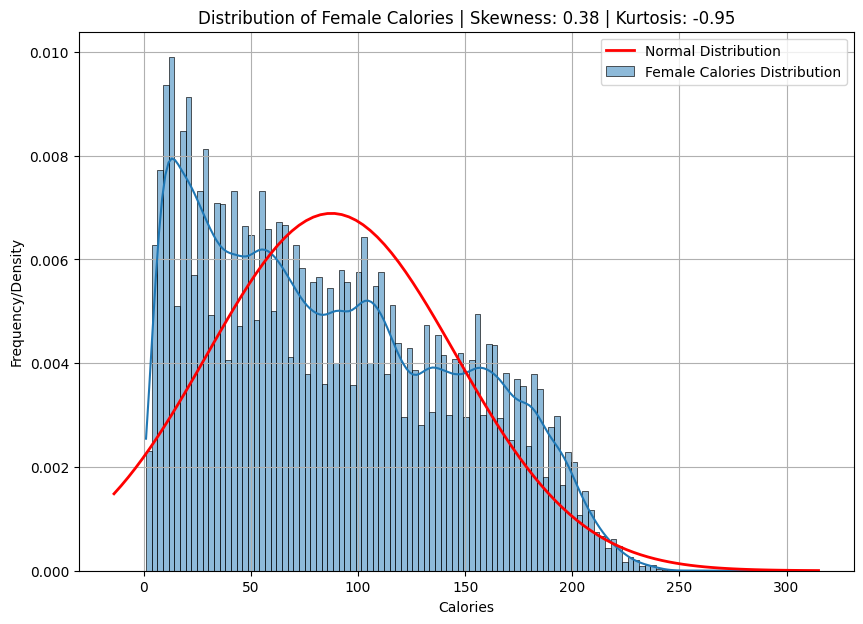

In [15]:
plt.figure(figsize=(10, 7))
sns.histplot(female_df['Calories'], kde=True, bins='auto', edgecolor='black', label='Female Calories Distribution', stat='density')

mean = female_df['Calories'].mean()
std = female_df['Calories'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution')

plt.grid(True, linestyle='-')
plt.title(f"Distribution of Female Calories | Skewness: {round(female_df['Calories'].skew(), 2)} | Kurtosis: {round(female_df['Calories'].kurtosis(), 2)}")
plt.xlabel('Calories')
plt.ylabel('Frequency/Density')
plt.legend()
plt.show()

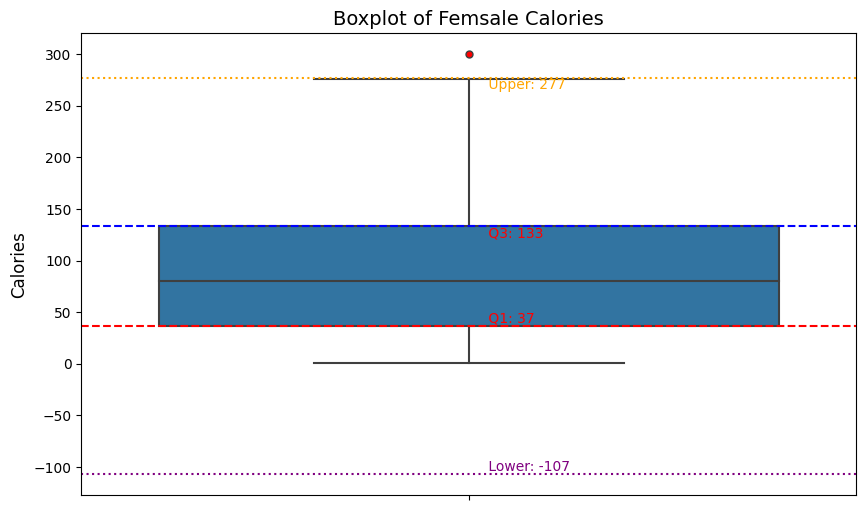

In [16]:
Q1 = female_df['Calories'].quantile(0.25)
Q3 = female_df['Calories'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(10, 6))
ax = sns.boxplot(y=female_df['Calories'], flierprops=dict(markerfacecolor='red', marker='o'))

plt.axhline(Q1, color='red', linestyle='--', label=f"Q1 = {Q1:,.0f}")
plt.axhline(Q3, color='blue', linestyle='--', label=f"Q3 = {Q3:,.0f}")
plt.axhline(lower_bound, color='purple', linestyle=':', label=f"Lower Bound = {lower_bound:,.0f}")
plt.axhline(upper_bound, color='orange', linestyle=':', label=f"Upper Bound = {upper_bound:,.0f}")

plt.text(0.02, Q1, f' Q1: {Q1:,.0f}', color='red', va='bottom')
plt.text(0.02, Q3, f' Q3: {Q3:,.0f}', color='red', va='top')
plt.text(0.02, lower_bound, f' Lower: {lower_bound:,.0f}', color='purple', va='bottom')
plt.text(0.02, upper_bound, f' Upper: {upper_bound:,.0f}', color='orange', va='top')


plt.title('Boxplot of Femsale Calories', fontsize=14)
plt.ylabel('Calories', fontsize=12)

plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

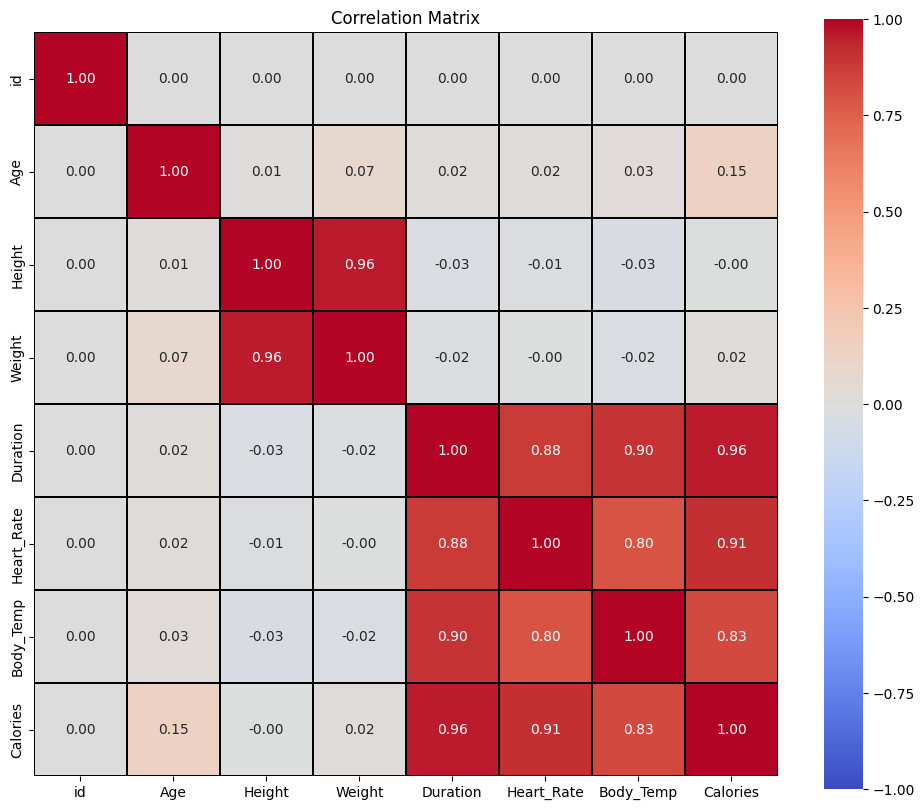

In [17]:
corr_df = train.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm", linecolor='black', linewidths=0.3, square=True)
plt.title('Correlation Matrix')

Text(0.5, 1.0, 'Correlation Matrix Zoomed on Dependant Variable')

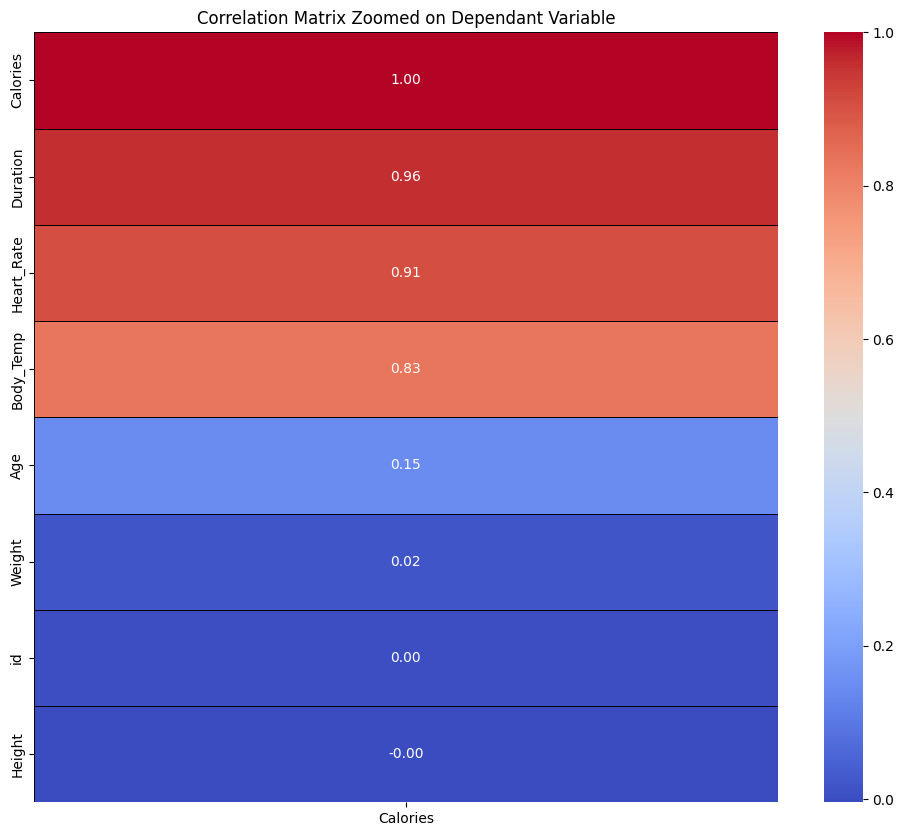

In [18]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df[['Calories']].sort_values(by='Calories', ascending=False), annot=True, cmap="coolwarm", fmt=".2f", linecolor='black', linewidths=0.5)
plt.title('Correlation Matrix Zoomed on Dependant Variable')

# Data Transformation

In [19]:
# https://integrishealth.org/resources/on-your-health/2015/october/stages-of-life-health-for-every-age
def classify_age(age):
    if 5 <= age <= 12:
        return 'Child'
    elif 13 <= age <= 19:
        return 'Teenager'
    elif 20 <= age <= 39:
        return 'Adult'
    elif 40 <= age <= 59:
        return 'Middle Age Adult'
    elif age >= 60:
        return 'Senior Adult'
    else:
        return 'Unknown'

train['Age_Group'] = train['Age'].apply(classify_age)
test['Age_Group'] = test['Age'].apply(classify_age)

In [20]:
# BMI Calculation
# BMI = weight (kg) / (height (m))^2
train['Height_m'] = train['Height'] / 100  # i will assume this in cm
train['BMI'] = train['Weight'] / (train['Height_m'] ** 2)
train.drop(columns='Height_m', inplace=True)

test['Height_m'] = test['Height'] / 100
test['BMI'] = test['Weight'] / (test['Height_m'] ** 2)
test.drop(columns='Height_m', inplace=True)

In [21]:
# https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations
# BMI Category
def bmi_category(row):
    age = row['Age']
    bmi = row['BMI']
    
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal Weight'
    elif 25 <= bmi < 30:
        return 'Pre-Obesity'
    else:
        return 'Obesity'

train['BMI_Category'] = train.apply(bmi_category, axis=1)
test['BMI_Category'] = test.apply(bmi_category, axis=1)

In [22]:
# https://health.clevelandclinic.org/exercise-heart-rate-zones-explained
# Heart Rate Classification
def determine_heart_rate_zone(row, resting_hr=70):
    age = row['Age']
    current_hr = row['Heart_Rate']

    max_hr = 220 - age
    hr_reserve = max_hr - resting_hr

    zone1 = hr_reserve * 0.5 + resting_hr
    zone2 = hr_reserve * 0.6 + resting_hr
    zone3 = hr_reserve * 0.7 + resting_hr
    zone4 = hr_reserve * 0.8 + resting_hr
    zone5 = hr_reserve * 0.9 + resting_hr

    if current_hr < zone1:
        return 'Below Zone 1'
    elif zone1 <= current_hr < zone2:
        return 'Zone 1'
    elif zone2 <= current_hr < zone3:
        return 'Zone 2'
    elif zone3 <= current_hr < zone4:
        return 'Zone 3'
    elif zone4 <= current_hr < zone5:
        return 'Zone 4'
    else:
        return 'Zone 5'

train['Heart_Rate_Zone'] = train.apply(determine_heart_rate_zone, axis=1)
test['Heart_Rate_Zone'] = test.apply(determine_heart_rate_zone, axis=1)


In [23]:
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (750000, 13)
Test Shape: (250000, 12)


In [24]:
nominal_features = {
    'Sex': ['male', 'female']
}

ordinal_features = {
    'Age_Group': [
        'Child',             # 5–12 years
        'Teenager',          # 13–19 years
        'Adult',             # 20–39 years
        'Middle Age Adult',  # 40–59 years
        'Senior Adult'       # 60+ years
    ],
    
    'BMI_Category': [
        'Underweight',       # BMI < 18.5
        'Normal Weight',     # 18.5 ≤ BMI < 25
        'Pre-Obesity',       # 25 ≤ BMI < 30
        'Obesity'            # BMI ≥ 30
    ],

    'Heart_Rate_Zone': [
        'Below Zone 1',
        'Zone 1',
        'Zone 2',
        'Zone 3',
        'Zone 4',
        'Zone 5'
    ]
}


In [25]:
ohe = OneHotEncoder(categories=[nominal_features['Sex']], 
                    handle_unknown='error', 
                    sparse=False)

train_dummy = ohe.fit_transform(train[['Sex']])
test_dummy = ohe.transform(test[['Sex']])

dummy_cols = ohe.get_feature_names_out(['Sex'])

train_dummy = pd.DataFrame(train_dummy, columns=dummy_cols, index=train.index)
test_dummy = pd.DataFrame(test_dummy, columns=dummy_cols, index=test.index)

nom_cat = ['Sex']
train = pd.concat([train, train_dummy], axis=1)
test  = pd.concat([test, test_dummy],  axis=1)

In [26]:
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (750000, 15)
Test Shape: (250000, 14)


In [27]:
ord_cat = ['Age_Group', 'BMI_Category', 'Heart_Rate_Zone']
oe = OrdinalEncoder(categories=[ordinal_features[col] for col in ord_cat],
                            handle_unknown='use_encoded_value',
                            unknown_value=-1)

train[ord_cat] = oe.fit_transform(train[ord_cat])
test[ord_cat] = oe.transform(test[ord_cat])

In [28]:
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")

Train Shape: (750000, 15)
Test Shape: (250000, 14)


In [29]:
X_train, y_train = train[train.columns[1:]].copy(), train['Calories'].copy()
X_test = test[test.columns[1:]].copy()

X_train.drop(['Calories'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2,
    stratify=train['Sex'],
    random_state=42
)

X_train.drop(['Sex'], axis=1, inplace=True)
X_test.drop(['Sex'], axis=1, inplace=True)
X_valid.drop(['Sex'], axis=1, inplace=True)

# Model Building

In [30]:
def rmsle_score(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

In [31]:
# results = pd.DataFrame(columns=['Model', 'MSE Train'])
# models = {
#     'ElasticNet (default)': ElasticNet(random_state=42),
#     'RandomForest (default)': RandomForestRegressor(random_state=42),
#     'XGBoost (default)': XGBRegressor(random_state=42)
# }

# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_train)
#     mse_train = mean_squared_error(y_train, y_pred)
    
#     new_row = pd.DataFrame([{'Model': name, 'MSE Train': mse_train}])
#     results = pd.concat([results, new_row], ignore_index=True)

# # Show results
# results.sort_values(by='MSE Train', ascending=True, inplace=True)
# results.reset_index(drop=True, inplace=True)
# print(results)

In [32]:
# preds = XGBRegressor(random_state=42).fit(X_train, y_train).predict(X_test)
# y_pred = pd.DataFrame({'id': test['id'],'Calories': abs(preds)})
# y_pred.to_csv('submission_xgb.csv', index=False)

In [33]:
# preds = RandomForestRegressor(random_state=42).fit(X_train, y_train).predict(X_test)
# y_pred = pd.DataFrame({'id': test['id'],'Calories': preds})
# y_pred.to_csv('submission_rf.csv', index=False)

In [34]:
# sample.head()

In [35]:
# y_pred.describe()

In [36]:


# X_train_gpu = cp.asarray(X_train.values)
# X_test_gpu = cp.asarray(X_test.values)

# dtrain = DMatrix(X_train_gpu, label=y_train.values)
# dtest = DMatrix(X_test_gpu)

## RandomForest

In [37]:
rf_model = RandomForestRegressor(random_state=42, )

rf_search_space = {
    'n_estimators': Integer(100, 700),
    'max_depth': Integer(2, 10),
    'min_samples_split': Integer(2, 6),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2'])
}

# Bayesian optimization with cross-validation
rf_opt = BayesSearchCV(
    estimator=rf_model,
    search_spaces=rf_search_space,
    scoring=rmsle_scorer,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_opt.fit(X_train, y_train)
print("Training Complete")
print(f"Best Score: {rf_opt.best_score_}")
print(f"Best Params:\n{rf_opt.best_params_}")

preds = rf_opt.predict(X_test)
y_pred = pd.DataFrame({'id': test['id'],'Calories': preds})
y_pred.to_csv('submission_rf.csv', index=False)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training Complete
Best Score: -0.1254890845030689
Best Params:
OrderedDict([('max_depth', 10), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 4), ('n_estimators', 329)])


In [38]:
# importances_rf = rf_opt.best_estimator_.feature_importances_
# features_rf = pd.Series(importances_rf, index=X_train.columns)
# top_20_rf = features_rf.sort_values(ascending=False).head(30)

# # Display top 20
# top_20_rf.plot(kind='barh', title='Top 20 Features - Random Forest', figsize=(8,6))
# plt.gca().invert_yaxis()
# plt.xlabel("Importance")
# plt.show()

## XGBoost

In [39]:
xgb_model = XGBRegressor(
    random_state=42,
    objective='reg:squaredlogerror',
    eval_metric=['rmsle', 'rmse'],
    tree_method='hist',
    early_stopping_rounds=2
)

xgb_search_space = {
    'n_estimators': Integer(100, 700),
    'max_depth': Integer(2, 10),
    'learning_rate': Real(1e-5, 0.2, prior='log-uniform'),
    'subsample': Real(0.7, 1.0),
    'colsample_bytree': Real(0.7, 1.0)
    # 'tree_method': Categorical(['auto', 'exact', 'approx', 'hist'])
}

eval_set = [(X_valid, y_valid)]

xgb_opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=xgb_search_space,
    scoring='neg_root_mean_squared_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_opt.fit(X_train, 
            y_train,
            eval_set=eval_set,
            verbose=0)
print("Training Complete")
print(f"Best Score: {xgb_opt.best_score_}")
print(f"Best Params:\n{xgb_opt.best_params_}")

preds = xgb_opt.predict(X_test)
y_pred = pd.DataFrame({'id': test['id'],'Calories': preds})
y_pred.to_csv('submission_xgb.csv', index=False)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training Complete
Best Score: -5.460930815238834
Best Params:
OrderedDict([('colsample_bytree', 0.9512165066659852), ('learning_rate', 0.0629746124706503), ('max_depth', 4), ('n_estimators', 671), ('subsample', 0.9592383746394852)])


# Deep Learning

In [40]:
# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# import tensorflow.keras.backend as K
# from tensorflow.keras.metrics import MeanSquaredLogarithmicError 

In [41]:
# model = Sequential([
#     Input(shape=(X_train.shape[1],)),
    
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.4),
    
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.2),
    
#     Dense(32, activation='relu'),
#     Dense(1, activation='linear')
# ])

# model.compile(
#     optimizer=Adam(learning_rate=0.001), 
#     loss='mean_squared_logarithmic_error',
#     metrics=['mean_squared_error']
# )

# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_valid, y_valid),
#     epochs=25,
#     batch_size=256,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

In [42]:
# # Visualize loss and MSLE during training
# def plot_training_history(history):
#     # Retrieve the loss and metric values
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     msle = history.history['mean_squared_error']
#     val_msle = history.history['val_mean_squared_error']

#     # Plot training & validation loss
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(loss, label='Training Loss')
#     plt.plot(val_loss, label='Validation Loss')
#     plt.title('Loss (MSLE) during Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot training & validation MSLE
#     plt.subplot(1, 2, 2)
#     plt.plot(msle, label='Training MSE')
#     plt.plot(val_msle, label='Validation MSE')
#     plt.title('MSE (Mean Squared Error) during Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('MSLE')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Call the function after training
# plot_training_history(history)


In [43]:
# preds = model.predict(X_test).flatten()
# y_pred = pd.DataFrame({'id': test['id'],'Calories': preds})
# y_pred.to_csv('submission_nn.csv', index=False)